# Visualize nPRFs

--> visually check how useful they might be as seedTS (its vertices) for connectivity/PPI
$$ $$
observartions: e.g. sub-58 nPRFs lie very laterally (almost on TPJ) -- NPC regions dont align in macroanatomy!

In [2]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.utils.parcellation import reduce_by_labels
import numpy as np
import os.path as op
from numrisk.fmri_analysis.gradients.utils import cleanTS, get_glasser_parcels
import seaborn as sns
import pandas as pd
import os
import nilearn.plotting as nplt
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 
plot_folder = os.path.join(bids_folder, 'plots_and_ims/nPRFs')
os.makedirs(plot_folder) if not op.exists(plot_folder) else None

# group list
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')

from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()


In [ ]:
# Get Glasser parcellation and mask
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping, get_glasser_parcels
from brainspace.utils.parcellation import map_to_labels
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )
from utils_01 import get_cleanTS_run, get_events_confounds
import statsmodels.api as sm

In [67]:
import nibabel as nib
def get_nPRFs_params(sub, bids_folder,par='r2',  space='fsaverage5'): # key='encoding_model.denoise',
    key ='encoding_model.cv.denoise'if par =='cvr2' else 'encoding_model.denoise'
    nPRF_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1','func')
    nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-{space}_hemi-L.func.gii')
    nprf_r2_L = nib.load(nPRF_fn).agg_data()
    nPRF_fn =  op.join(nPRF_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-{space}_hemi-R.func.gii')
    nprf_r2_R = nib.load(nPRF_fn).agg_data()
    nprf_r2 = np.concatenate((nprf_r2_L, nprf_r2_R))
    return nprf_r2

[Text(0.5, 1.0, 'nPRF r2'), Text(0.5, 0, 'r2'), Text(0, 0.5, 'Density')]

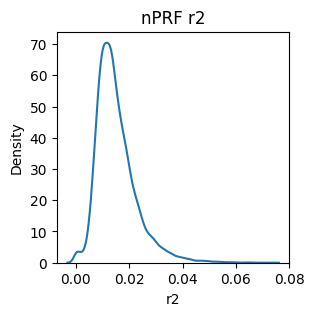

In [71]:
#from utils import get_nPRFs_params, get_NPC_mask

sub = '58'
par = 'r2'
# Get nPRFs params
r2_ = get_nPRFs_params(sub, bids_folder, par=par)
mask_NPC = get_NPC_mask(bids_folder)

fig, axes = plt.subplots(1,1, figsize=(3,3))
sns.kdeplot(r2_[~mask_NPC])
axes.set(title=f'nPRF {par}', xlabel=par, ylabel='Density')

In [54]:
views = ['medial','lateral','dorsal','posterior']

Text(0.5, 0.85, 'r2 nPRF, \n sub-58')

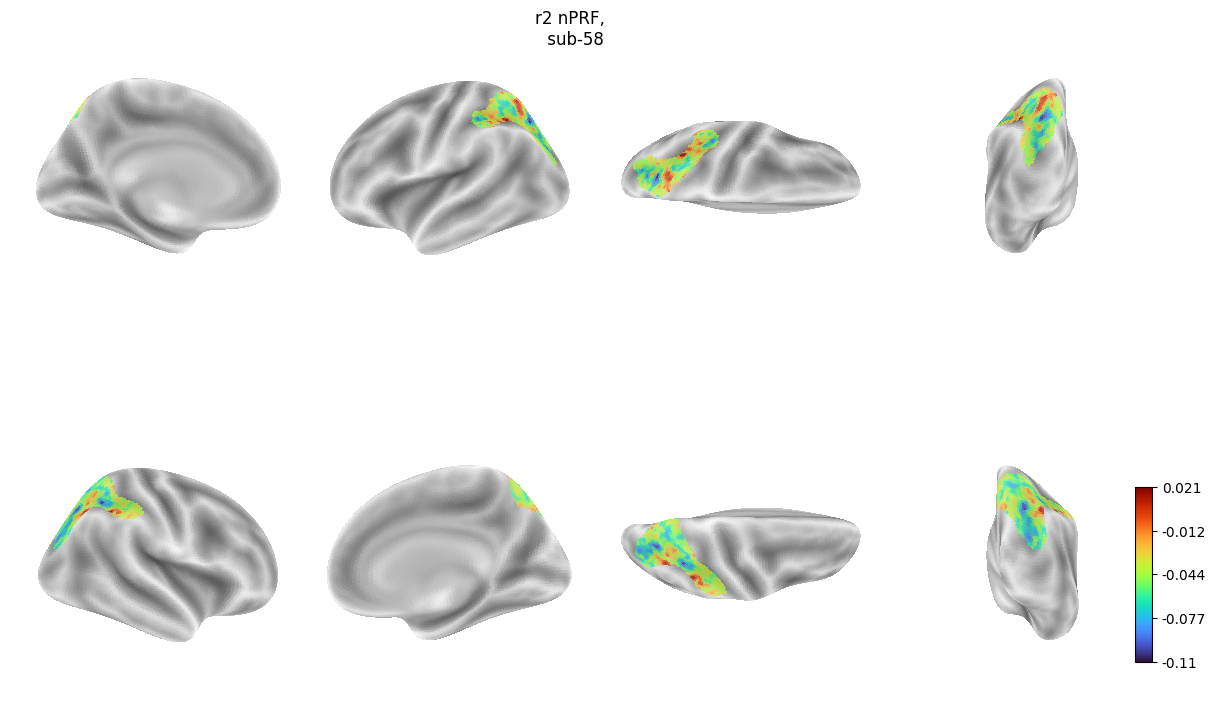

In [56]:
cmap = 'turbo' 
r2 = r2_.copy()
r2[~mask_NPC] = np.nan

figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))
for j, hemi in enumerate(['L','R']):

    map = np.split(r2,2)[j]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
    Tval_extrem = np.max(np.abs(np.nan_to_num(r2, nan=0.0, posinf=0.0, neginf=0.0)))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' and hemi == 'R' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map, #vmin=-Tval_extrem, vmax=Tval_extrem,
                view= view,cmap=cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

figure.subplots_adjust(wspace=0.01, hspace=0.01)
figure.suptitle(f'r2 nPRF, \n sub-{sub}', y=0.85) # for p-val < 0.05
#plt.savefig(os.path.join(plot_folder, f'ppi_{param}_1sTstat_seedParcel-{seed_parcel_n}.png'), bbox_inches='tight', pad_inches=0.1)

Text(0.5, 0.85, 'r2 nPRF sub-58 \n thresh: r2>0.0')

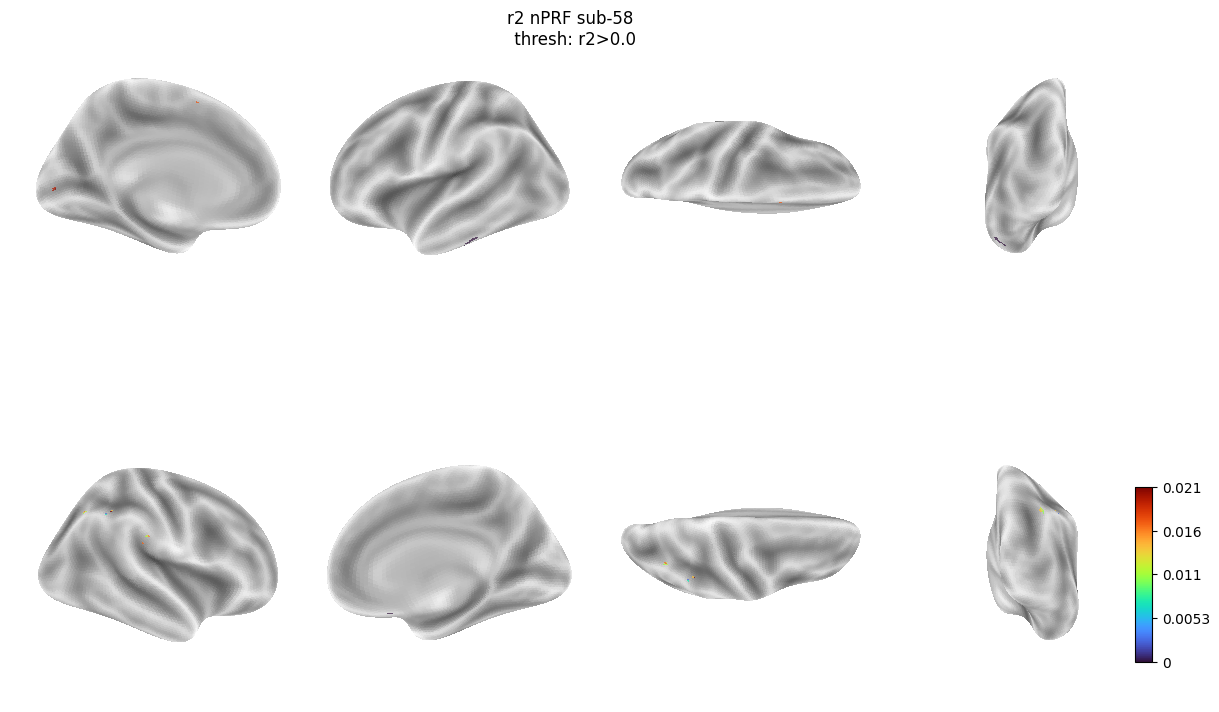

In [64]:
cmap = 'turbo' 
thresh = 0.
map = r2_.copy()
map[r2_ < thresh] = np.nan

figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))
for j, hemi in enumerate(['L','R']):

    surf_map = np.split(map,2)[j]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
    Tval_extrem = np.max(np.abs(np.nan_to_num(r2, nan=0.0, posinf=0.0, neginf=0.0)))
    for i,view in enumerate(views):
        colbar = True if view == 'posterior' and hemi == 'R' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= surf_map, #vmin=-Tval_extrem, vmax=Tval_extrem,
                view= view,cmap=cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

figure.subplots_adjust(wspace=0.01, hspace=0.01)
figure.suptitle(f'r2 nPRF sub-{sub} \n thresh: r2>{thresh}', y=0.85) # for p-val < 0.05
#plt.savefig(os.path.join(plot_folder, f'ppi_{param}_1sTstat_seedParcel-{seed_parcel_n}.png'), bbox_inches='tight', pad_inches=0.1)

## Loop over subs & save figs

In [15]:
cmap = 'turbo' 
thresh = 0.02

for subject in range(1, 67):
    try:
        sub = f'{int(subject):02d}'
        r2 = get_nPRFs_params(sub, bids_folder)


        map = r2.copy()
        map[r2 < thresh] = np.nan

        figure, axes = plt.subplots(nrows=2, ncols=len(views),figsize = (15,10), subplot_kw=dict(projection='3d'))
        for j, hemi in enumerate(['L','R']):

            surf_map = np.split(map,2)[j]
            surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
            bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
            Tval_extrem = np.max(np.abs(np.nan_to_num(r2, nan=0.0, posinf=0.0, neginf=0.0)))
            for i,view in enumerate(views):
                colbar = True if view == 'posterior' and hemi == 'R' else False
                nplt.plot_surf(surf_mesh=surf_mesh , surf_map= surf_map, #vmin=-Tval_extrem, vmax=Tval_extrem,
                        view= view,cmap=cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                        bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[j,i]) 

        figure.subplots_adjust(wspace=0.01, hspace=0.01)
        figure.suptitle(f'r2 nPRF sub-{sub} \n thresh: r2>{thresh}', y=0.85) # for p-val < 0.05
        plt.savefig(os.path.join(plot_folder, f'sub-{sub}_r2-nPRF_thresh-{thresh}.png'), bbox_inches='tight', pad_inches=0.1)
        plt.close('all')
    except:
        print(f'Error with sub-{sub}')

Error with sub-03
